In [19]:
import mujoco
import jax
import brax
import numpy as np
from jax import numpy as jp
from brax import actuator
from brax import geometry
from brax import kinematics
from brax.io import mjcf
from brax.base import System
from brax.generalized import pipeline
from brax.generalized import constraint
from brax.generalized import dynamics
from brax.generalized import integrator
from brax.generalized import mass
from brax.generalized.base import State

from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

import mediapy as media
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
rc('animation', html='jshtml')

%env MUJOCO_GL=egl

tpu
env: MUJOCO_GL=egl


In [43]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          96
On-line CPU(s) list:             0-95
Thread(s) per core:              2
Core(s) per socket:              24
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                        3
CPU MHz:                         2000.076
BogoMIPS:                        4000.15
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       1.5 MiB
L1i cache:                       1.5 MiB
L2 cache:                        48 MiB
L3 cache:                        77 MiB
NUMA node0 CPU(s):               0-23,48-71
NUM

In [ ]:
def visualize(axes, pos, alpha=1, dummy=True):
    assert axes.shape == (3,)
    x_arm = jp.vstack([jp.zeros((1,3)), pos[:8]])
    title = ['X-Z view', 'X-Y view', 'Y-Z view']
    xlim = [(-1, 1), (-1, 1), (-1, 1)]
    ylim = [(-0.5, 1.5), (-1, 1), (-0.5, 1.5)]
    for i in range(3):
        axes[i].plot(x_arm[:, i//2], x_arm[:, 2-i%2], linewidth=5, label='Arm', alpha=alpha)
        axes[i].scatter(pos[:7, i//2], pos[:7, 2-i%2], s=150, c='orange', edgecolors='face', label='Joint')
        axes[i].grid()
        axes[i].set_title(title[i])
        axes[i].set_xlabel(title[i][0:1])
        axes[i].set_ylabel(title[i][2:3])
        axes[i].set_xlim(*xlim[i])
        axes[i].set_ylim(*ylim[i])
    legend = axes[-1].legend(['Arm'], loc='upper right', title='Components', bbox_to_anchor=(1.4, 1))
    axes[-1].add_artist(legend)

In [51]:
def sketch_render(xpos, save_name="figure/panda_slim.gif"):
    rc('animation', html='jshtml')
    fig, ax = plt.subplots()
    plt.xlim([-1, 1])
    plt.ylim([-0.5, 1.5])
    plt.axis ('equal')
    ax.grid()

    n = len(xpos)
    line, = ax.plot(xpos[0, :, 0], xpos[0, :, 2], linewidth=5)
    scat = ax.scatter(xpos[0, :, 0], xpos[0, :, 2], s=150, c='orange', edgecolors='face')
    plt.show()

    def init():
        return line,

    def animate(i):
        x, z = xpos[i, :, 0], xpos[i, :, 2]
        line.set_data(x, z)
        scat.set_offsets(jp.vstack([x, z]).T)
        return line, 

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=n, interval=20, blit=False, repeat=True)
    plt.close()
    anim.save("figure/panda_slim.gif")


# Dummy Joint0

### Load Model

In [59]:
path = f'env/panda_slim_dummy_joint.xml'
# mj = mujoco.MjModel.from_xml_path(path)
# sys = mjcf.load_model(mj)
sys = mjcf.load(path)

Look up joints' velocity $qd$ and position $q$

In [60]:
sys.q_size(), sys.init_q.shape[0], sys.qd_size()

(8, 8, 8)

Look up links count and type

In [61]:
sys.num_links(), sys.link_types, len(sys.link_types)

(8, '11111111', 8)

In [62]:
list(zip(sys.link_names, sys.link_parents, sys.link_types, sys.dof_ranges()))

[('link0', -1, '1', [0]),
 ('link1', 0, '1', [1]),
 ('link2', 1, '1', [2]),
 ('link3', 2, '1', [3]),
 ('link4', 3, '1', [4]),
 ('link5', 4, '1', [5]),
 ('link6', 5, '1', [6]),
 ('link7', 6, '1', [7])]

### Visualize the model

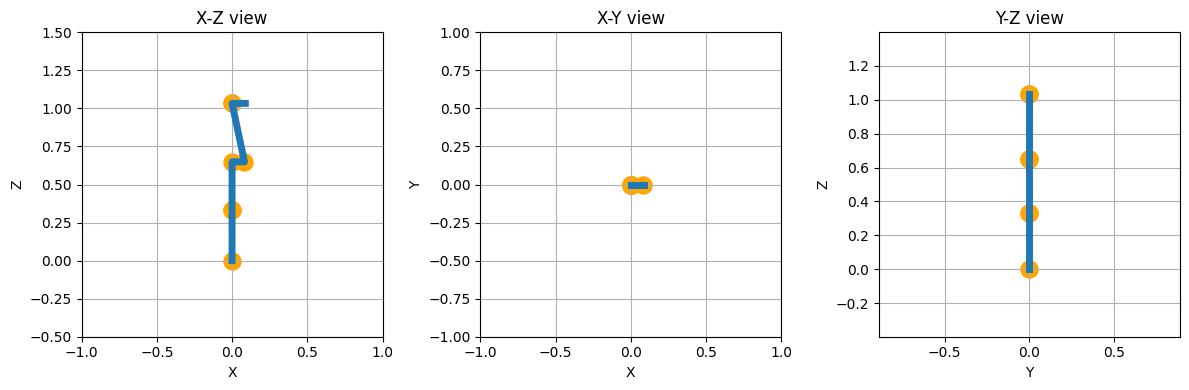

In [56]:
# Time: 4m50s
q = sys.init_q
qd = jp.zeros(sys.qd_size())
x, xd = kinematics.forward(sys, q, qd)
state = jax.jit(pipeline.init)(sys, q, qd)

assert state.x.pos.all() == x.pos.all()

_, axes = plt.subplots(1,3, figsize=(12, 4))
plt.axis ('equal')
visualize(axes, x.pos, alpha=1)
plt.tight_layout()

### Update Model

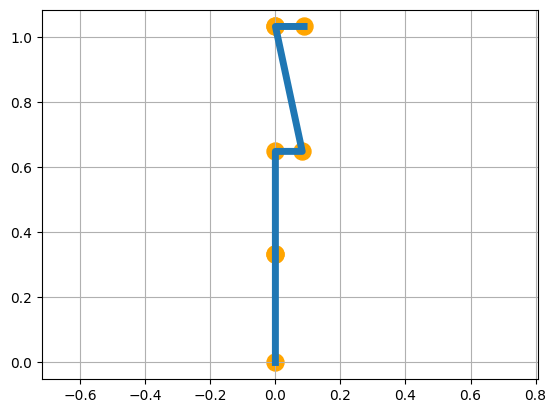

In [63]:
# Time: 4m43
act = jp.array([0, 0, 0, -1.57079, 0, 1.57079, -0.7853])
q = sys.init_q
qd = jp.zeros(sys.qd_size())
state = jax.jit(pipeline.init)(sys, q, qd)

xpos = []
for i in range(300):
    state = jax.jit(pipeline.step)(sys, state, act)
    xpos.append(state.x.pos)

sketch_render(jp.array(xpos), save_name="figure/panda_slim_dummy_joint.gif")

In [64]:
media.show_video(media.read_video("figure/panda_slim_dummy_joint.gif"))

# Without dummy joint0

In [31]:
path = f'env/panda_slim.xml'
sys = mjcf.load(path)

In [32]:
sys.q_size(), sys.init_q.shape[0], sys.qd_size()

(7, 7, 7)

In [33]:
list(zip(sys.link_names, sys.link_parents, sys.link_types, sys.dof_ranges()))

[('link1', -1, '1', [0]),
 ('link2', 0, '1', [1]),
 ('link3', 1, '1', [2]),
 ('link4', 2, '1', [3]),
 ('link5', 3, '1', [4]),
 ('link6', 4, '1', [5]),
 ('link7', 5, '1', [6])]

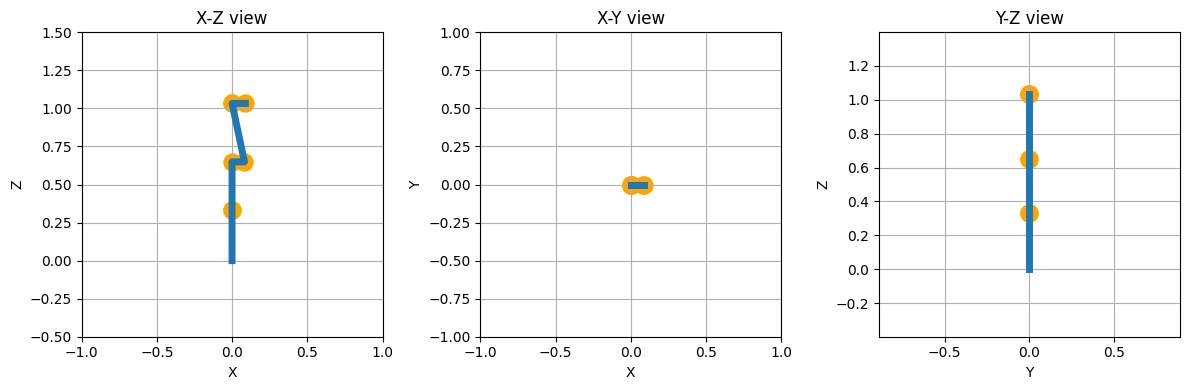

In [34]:
# Time: 3m42s
q = sys.init_q
qd = jp.zeros(sys.qd_size())
# x, xd = kinematics.forward(sys, q, qd)
state = jax.jit(pipeline.init)(sys, q, qd)

assert state.x.pos.all() == x.pos.all()

_, axes = plt.subplots(1,3, figsize=(12, 4))
plt.axis ('equal')
visualize(axes, x.pos, alpha=1)
plt.tight_layout()

In [35]:
# Time 3m36s
act = jp.array([0, 0, 0, -1.57079, 0, 1.57079, -0.7853])
q = sys.init_q
qd = jp.zeros(sys.qd_size())
state = jax.jit(pipeline.init)(sys, q, qd)

xpos = []
for i in range(300):
    state = jax.jit(pipeline.step)(sys, state, act)
    xpos.append(state.x.pos)

In [39]:
xpos[0].shape

(7, 3)

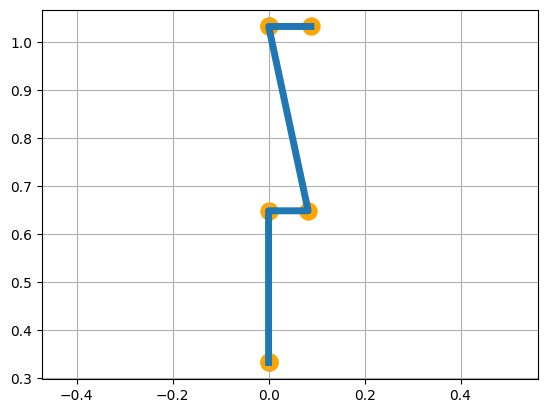

In [40]:
sketch_render(jp.array(xpos), save_name="figure/panda_slim.gif")

""

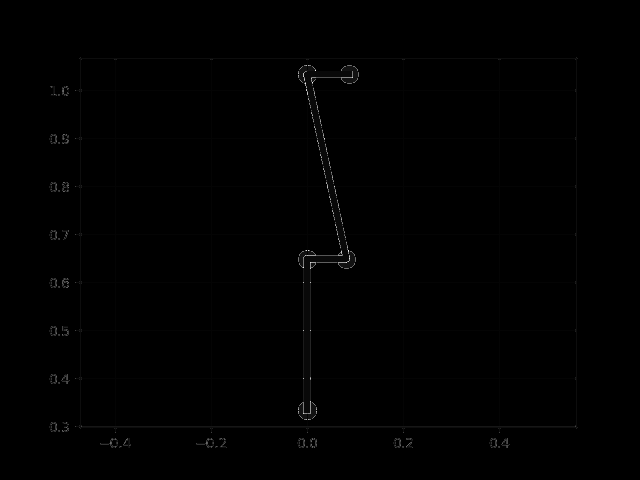

In [41]:
media.show_video(media.read_video("figure/panda_slim.gif"))